In [1]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
%matplotlib inline
from scipy import special
from scipy import signal
import copy

# append path for loading own packages
import sys
sys.path.append("../packages")

# import own packages
import edges
import grating
from auxiliary import theta
from auxiliary import feature_pixels
import auxiliary as aux
import func2areamap
import jitter
import density
import imaging as imgg

In [3]:
hfs         = 2.
pitch       = 6.
edge_width  = 0.5
edge_height = 1.

edge_fct    = edges.make_erf_edge(edge_width, edge_height)

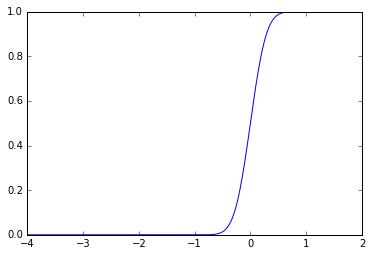

In [4]:
xmin_final_edge = (hfs - pitch) / 2
xmax_final_edge = hfs / 2
xres_final_edge = 128

xmin_work_edge  = 2*xmin_final_edge
xmax_work_edge  = 2*xmax_final_edge
xres_work_edge  = 2*xres_final_edge
x_work_edge     = np.linspace(xmin_work_edge, xmax_work_edge, xres_work_edge)

plt.plot(x_work_edge, edge_fct(x_work_edge))

edge image extent = [-4.0, 2.0, -0.5, 1.5]
edge image shape = (256, 256)
x_pixsize = 0.0234375


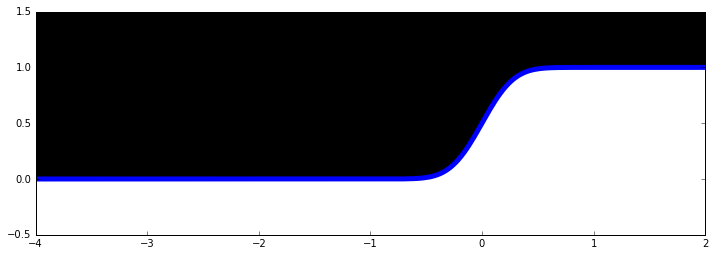

In [4]:
ymin = -0.5
ymax = 1.5
yres = 2*xres_final_edge

y = np.linspace(ymin, ymax, yres)

edge_img = func2areamap.func2areamap(x_work_edge, y, edge_fct(x_work_edge))
edge_img_extent = [xmin_work_edge, xmax_work_edge, ymin, ymax]

fig = plt.figure(figsize=(12,6))
aux.imshow(edge_img.T, extent=edge_img_extent)
plt.plot(x_work_edge, edge_fct(x_work_edge), linewidth=5)
print("edge image extent = {}".format(edge_img_extent))
print("edge image shape = {}".format(edge_img.shape))
print("x_pixsize = {}".format((edge_img_extent[1]-edge_img_extent[0])/edge_img.shape[0]))

smoothed extent = [-3.71875, 1.71875, -0.49609375, 1.49609375]
smoothed shape = (232, 255)
x_pixsize = 0.0234375


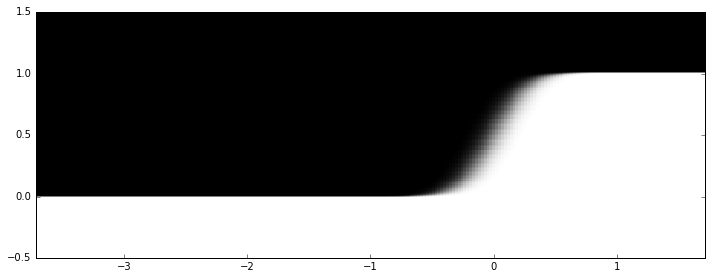

In [5]:
kernel = imgg.gaussian_kernel(edge_width/5, 0.01, (xmax_final_edge-xmin_final_edge)/xres_final_edge, 3)
smoothed_img, smoothed_extent = imgg.smooth(edge_img, kernel, edge_img_extent)

fig = plt.figure(figsize=(12,6))
aux.imshow(smoothed_img.T, extent=smoothed_extent)
print("smoothed extent = {}".format(smoothed_extent))
print("smoothed shape = {}".format(smoothed_img.shape))
print("x_pixsize = {}".format((smoothed_extent[1]-smoothed_extent[0])/smoothed_img.shape[0]))

cropped shape: (128, 255)
cropped extent: [-2.0078125, 0.9921875, -0.49609375, 1.49609375]
x_pixsize = 0.0234375


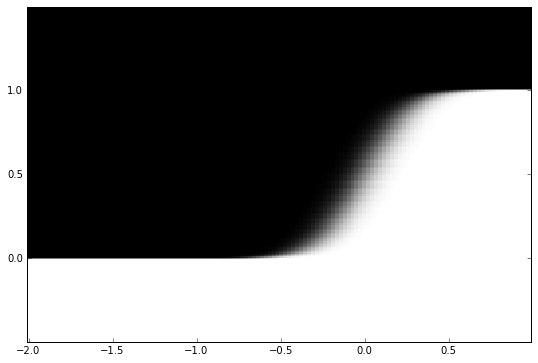

In [6]:
cropped_img, cropped_extent = imgg.crop(smoothed_img, smoothed_extent, \
                                   [xmin_final_edge, xmax_final_edge, ymin, ymax])

fig = plt.figure(figsize=(12,6))
aux.imshow(cropped_img.T, extent=cropped_extent)
print("cropped shape: {}".format(cropped_img.shape))
print("cropped extent: {}".format(cropped_extent))
print("x_pixsize = {}".format((cropped_extent[1]-cropped_extent[0])/cropped_img.shape[0]))

padded shape: (128, 256)
padded extent: [-2.0078125, 0.9921875, -0.49609375, 1.50390625]
x_pixsize = 0.0234375


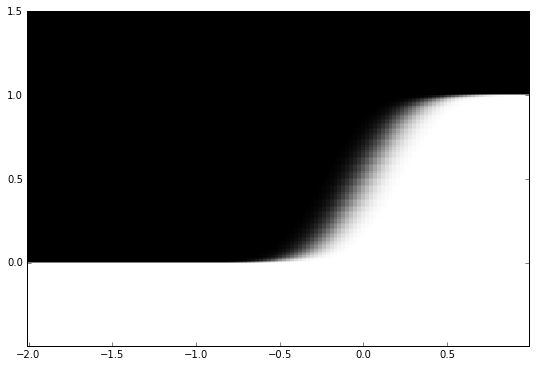

In [7]:
padded_img, padded_extent = imgg.pad(cropped_img, 128, 256, cropped_extent)

fig = plt.figure(figsize=(12,6))
aux.imshow(padded_img.T, extent=padded_extent)
print("padded shape: {}".format(padded_img.shape))
print("padded extent: {}".format(padded_extent))
print("x_pixsize = {}".format((padded_extent[1]-padded_extent[0])/padded_img.shape[0]))

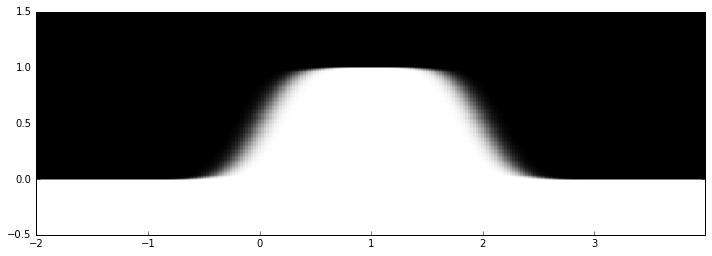

In [8]:
feature, feature_extent = imgg.symm_feat(padded_img, padded_extent)

fig = plt.figure(figsize=(12,6))
aux.imshow(feature.T, extent=feature_extent)

feature extent = [-2.0078125, 3.9921875, -0.49609375, 1.50390625]
translated extent = [-1.0234375, 4.9765625, -0.19921875, 1.80078125]
rolled extent = [-0.0390625, 5.9609375, 0.09765625, 2.09765625]


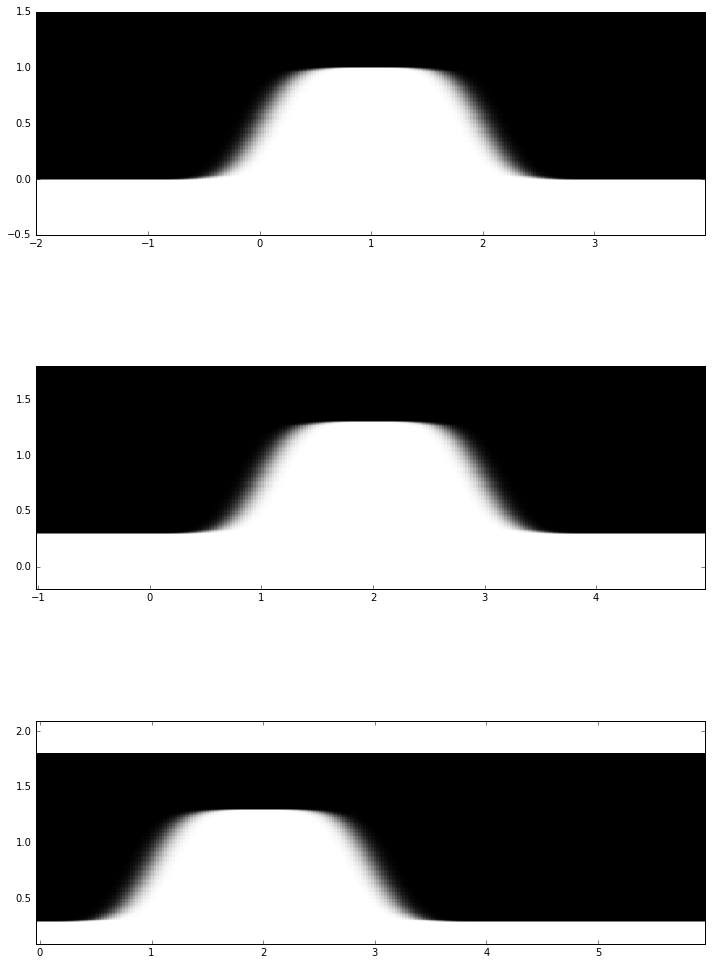

In [9]:
trans_img, trans_extent = imgg.translate(feature, feature_extent, 1, 0.3)
rolled_img, roll_extent   = imgg.roll(feature, feature_extent, 1, 0.3)

fig = plt.figure(figsize=(12, 18))
sub1 = fig.add_subplot(3, 1, 1)
aux.imshow(feature.T, extent=feature_extent)

sub2 = fig.add_subplot(3, 1, 2)
aux.imshow(trans_img.T, extent=trans_extent)

sub3 = fig.add_subplot(3, 1, 3)
aux.imshow(rolled_img.T, extent=roll_extent)

print("feature extent = {}".format(feature_extent))
print("translated extent = {}".format(trans_extent))
print("rolled extent = {}".format(roll_extent))

In [10]:
def density_grating(feature, feature_extent, xsize, dx):
    feature_width = feature_extent[1]-feature_extent[0]
    
    fig = plt.figure(figsize=(12,18))
    sub1 = fig.add_subplot(4, 1, 1) 
    temp, temp_extent = imgg.translate(feature, feature_extent, -feature_width, 0)
    aux.imshow(temp.T, extent=temp_extent)
    
    sub2 = fig.add_subplot(4, 1, 2) 
    temp, temp_extent = imgg.tile(temp, temp_extent, int((xsize+feature_width-1)/feature_width), 1)
    aux.imshow(temp.T, extent=temp_extent)
    
    sub3 = fig.add_subplot(4, 1, 3) 
    temp, temp_extent = imgg.translate(temp, temp_extent, dx, 0)
    aux.imshow(temp.T, extent=temp_extent)
    
    sub4 = fig.add_subplot(4, 1, 4) 
    temp, temp_extent = imgg.crop(temp, temp_extent, [feature_extent[0], feature_extent[0]+xsize, feature_extent[2], feature_extent[3]])
    aux.imshow(temp.T, extent=temp_extent)
    
    return temp, temp_extent

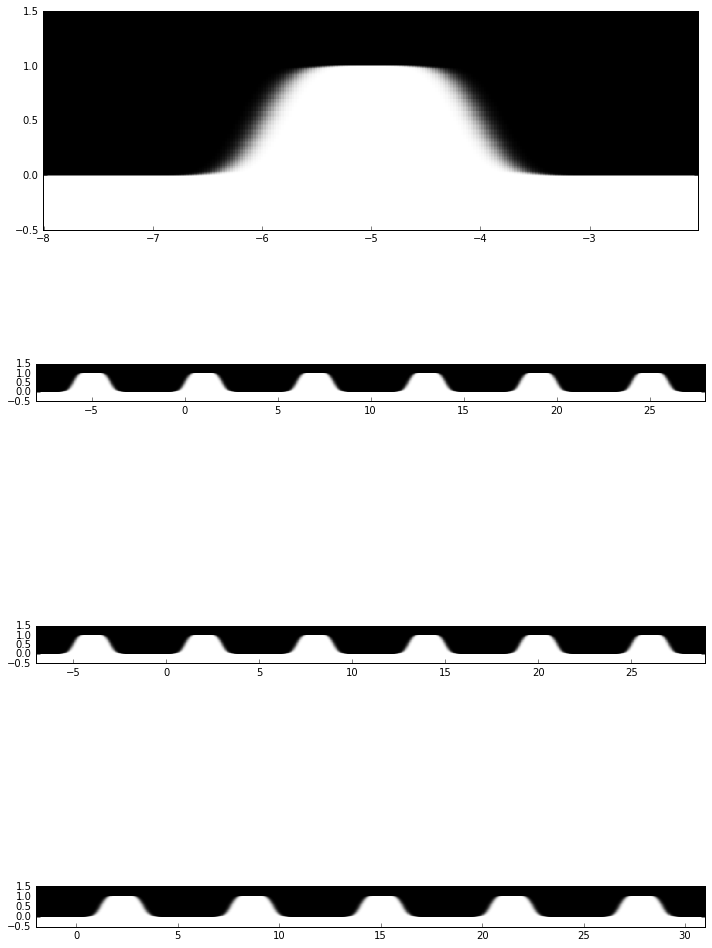

In [11]:
density_img, density_extent = density_grating(feature, feature_extent, 33, 1)


In [2]:
def make_foil_density(thick):
    f = lambda xp, yp, zp : theta(xp+thick) * theta(-xp)
    return f

foil_thick = 0.5
pitch = 1
vfs = 0.5 * pitch
hfs = 0.3 * pitch
focus_size = 5*pitch
smoothing_length = 0.1*hfs

xpmin = -0.5
xpmax = 2

ypmin = 0
ypmax = 5*pitch

zmin = aux.tcoords2rcoords(xpmax, 0, 0)[2]
zmax = aux.tcoords2rcoords(xpmin, 0, 0)[2]
zres = 128
z = np.linspace(zmin, zmax, zres)

ymin = 0
ymax = focus_size
yres = 1024
y = np.linspace(ymin, ymax, yres)

xmin = -focus_size/2
xmax =  focus_size/2
xres = 1024
x = np.linspace(xmin, xmax, xres)

yy, xx = np.meshgrid(y, x)

edge_fct    = edges.make_skewed_edge(hfs/3, vfs)
feature_fct = grating.symm_feat(hfs, edge_fct)
grating_fct = grating.feature_grating(pitch, feature_fct)
#jitter_fct  = jitter.make_jitter(hfs/5, hfs/2)
jitter_fct  = jitter.make_jitter(0, hfs/2)
density_fct = lambda xp, yp, zp : \
                density.make_density(grating_fct, jitter_fct)(xp, yp, zp) + \
                make_foil_density(foil_thick)(xp, yp, zp)

dd = np.zeros(shape=xx.shape)

kernel = imgg.gaussian_kernel(smoothing_length, smoothing_length, focus_size/xres)
kernel = kernel/kernel.sum()

In [5]:
def unpack_extent(extent):
    return extent[0], extent[1], extent[2], extent[3]

In [4]:
#for thisz in z:
for thisz in (z[zres//2],):
    xxp, yyp, zp = aux.rcoords2tcoords(xx, yy, thisz)
    xxp = xxp.T
    yyp = yyp.T
    dd = density_fct(xxp, yyp, zp)
    
    #this_xmin = aux.tcoords2rcoords(xpmax, 0, thisz)[0]
    #this_xmax = aux.tcoords2rcoords(xpmin, 0, thisz)[0]
    #extent = [ymin, ymax, this_xmin, this_xmax]
    #cropped_extent = [0, pitch, this_xmin, this_xmax]
    extent = [ymin, ymax, xmin, xmax]
    crop_extent = [ymin, ymin+pitch, -thisz-1.5*np.sqrt(2)*vfs, -thisz+0.5*np.sqrt(2)*vfs]
    
    cropped_img, cropped_extent = imgg.crop(dd, extent, crop_extent)
    smooth_img, smooth_extent = imgg.smooth(cropped_img, kernel, cropped_extent)
    tile_nx, tile_ny = cropped_img.shape[0], cropped_img.shape[1]
    padded_img, padded_extent = imgg.pad(smooth_img, tile_nx, tile_ny, smooth_extent)
    nx_tiles = int((xres+tile_nx-1)/tile_nx)
    ny_tiles = 1
    tiled_img, tiled_extent = imgg.tile(padded_img, padded_extent, nx_tiles, ny_tiles)
    out_img, out_extent = imgg.crop(tiled_img, tiled_extent, extent)
    #out_img, out_extent = imgg.pad(out_img, xres, yres, out_extent)
    out_img, out_extent = imgg.pad(out_img, yres, out_img.shape[1], out_extent)
    bottom_img, bottom_extent = imgg.crop(dd, extent, [ymin, ymax, cropped_extent[3], xmax])
    top_img, top_extent = imgg.crop(dd, extent, [ymin, ymax, xmin, cropped_extent[2]])
    #out_img = np.concatenate((top_img, out_img, bottom_img), axis=1)
    out_img = imgg.concatenate((top_img, out_img, bottom_img), (top_extent, out_extent, bottom_extent), axis=1)
print('extent         = {:05.3f}, {:05.3f}, {:05.3f}, {:05.3f}'.format(extent[0],extent[1],extent[2],extent[3]))
print('crop extent    = {:05.3f}, {:05.3f}, {:05.3f}, {:05.3f}'.format(crop_extent[0],crop_extent[1],crop_extent[2],crop_extent[3]))
print('cropped extent = {:05.3f}, {:05.3f}, {:05.3f}, {:05.3f}'.format(cropped_extent[0],cropped_extent[1],cropped_extent[2],cropped_extent[3]))
print('bottom extent  = {:05.3f}, {:05.3f}, {:05.3f}, {:05.3f}'.format(bottom_extent[0],bottom_extent[1],bottom_extent[2],bottom_extent[3]))
print('top extent     = {:05.3f}, {:05.3f}, {:05.3f}, {:05.3f}'.format(top_extent[0],top_extent[1],top_extent[2],top_extent[3]))
print('bottom shape   = {}, {}'.format(bottom_img.shape[0],bottom_img.shape[1]))
print('top shape   = {}, {}'.format(top_img.shape[0],top_img.shape[1]))
print('out shape   = {}, {}'.format(out_img.shape[0],out_img.shape[1]))
print(dd.shape)
print(cropped_img.shape)

fig = plt.figure(figsize=(12,18))

sub1 = fig.add_subplot(3, 2, 1)
aux.imshow(dd[:, ::1].T, extent=extent)

sub2 = fig.add_subplot(3, 2, 2)
aux.imshow(cropped_img[:, ::1].T, extent=cropped_extent)

sub3 = fig.add_subplot(3, 2, 3)
aux.imshow(smooth_img[:, ::1].T, extent=smooth_extent)

sub4 = fig.add_subplot(3, 2, 4)
aux.imshow(tiled_img[:, ::1].T, extent=tiled_extent)

sub5 = fig.add_subplot(3, 2, 5)
aux.imshow(out_img[:, ::1].T)

sub6 = fig.add_subplot(3, 2, 6)
aux.imshow((out_img-dd)[:, ::1].T)

Exception: Extents of images do not match

In [15]:
arf = ()
print(type(arf)==tuple)

True
